In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn
import scipy as sp

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy as sp
import scipy.interpolate as ip
import scipy.optimize as op
import scipy.signal as sg
import scipy.io

import tqdm.auto as tqdm

np.random.seed(123)

In [2]:
exp_dir = f"../data/experimental_spectra/topspin/4096/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma"]
exp_range = {"ampicillin": [1500, 2500],
             "aspala": [1500, 2500],
             "flutamide": [1500, 2500],
             "histidine": [1500, 2500],
             "thymol": [1500, 2500],
             "tyrosine": [1500, 2500],
             "mdma": [1600, 2400],
            }

fit_ranges = {"ampicillin": [[9.5, 12.]],
              "aspala": [[12., 15.], [-2., 1.5]],
              "flutamide": [[9.5, 12.]],
              "histidine": [[16., 20.], [11.5, 13.5], [4.5, 6.]],
              "thymol": [[8.5, 15.]],
              "tyrosine": [[12., 14.], [9.5, 11.5], [-2., 3.]],
              "mdma": [[1., 3.8]]}
bounds = [(None, None), (1.e-6, None), (0., 1.), (0., None)]
bounds_v = [(None, None), (1.e-6, None), (1.e-6, None), (0., None)]

ylabs_v = ["p", "wg", "wl", "h"]
ylabs_s = ["p", "w", "m", "h"]
ylabs_p = ["p", "w", "m", "h"]

w0s = np.linspace(0.1, 1, 10)
min_w_fit = 40000.

fig_dir = "../figures/GL_fitting_full_spectra/"
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
iso_dir = "../data/experimental_spectra/iso/"
exp_res = {"ampicillin": ["4k", "4k", "4k", "4k"],
           "aspala": ["4k", "4k", "4k", "4k", "4k"],
           "flutamide": ["2k", "2k", "2k", "2k"],
           "histidine": ["4k", "4k", "4k", "4k", "4k"],
           "thymol": ["4k", "4k", "4k", "4k"],
           "tyrosine": ["4k", "4k", "4k", "4k", "4k"],
           "mdma": ["4k", "4k", "4k", "4k"]}
exp_parts = {'ampicillin': ['NH3', 'NHAr5', 'Ar6104b', 'Me2'],
             'aspala': ['OH', 'NHNH3', 'CHCH', 'CH2', 'CH3'],
             'flutamide': ['H5b', 'H38', 'H6', 'H101112'],
             'histidine': ['H5', 'H7', 'H618', 'H9', 'H342'],
             'thymol': ['H7', 'H321c', 'H4', 'H556'],
             'tyrosine': ['COOH', 'OH', 'NH3H76', 'H5823', 'H3dia'],
             "mdma": ["R1ph_og_divby1456", "R2ph_og_divby1456", "R3ph_og_divby1456", "R4ph_og_divby1456"]}

# Load experimental data

In [3]:
def inverse_mas_fit(wr, a, b):
    
    y = a + b / wr
    
    return y

In [4]:
def inverse_mas2_fit(wr, a, b, c):
    
    y = a + b / wr + c / (np.square(wr))
    
    return y

In [5]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"

    with open(fr, "rb") as F:
        dr = np.fromfile(F, np.int32).astype(float)

    with open(fi, "rb") as F:
        di = np.fromfile(F, np.int32).astype(float)

    with open(f"{d}acqus", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$MASR"):
            wr = int(l.split("=")[1].strip())
        if l.startswith("##$TD="):
            TD = int(l.split("=")[1].strip())
        if l.startswith("##$SW_h="):
            SW = float(l.split("=")[1].strip())

    with open(f"{pd}procs", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$SI="):
            n_pts = int(l.split("=")[1].strip())

        if l.startswith("##$OFFSET="):
            offset = float(l.split("=")[1].strip())

        if l.startswith("##$SF="):
            SF = float(l.split("=")[1].strip())
            
    AQ = TD / (2 * SW)

    hz = offset * SF - np.arange(n_pts) / (2 * AQ * n_pts / TD)
    
    ppm = hz / SF

    return dr, di, wr, ppm, hz

In [6]:
def extract_exp_topspin(in_dir, compound):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X = []
    
    for d in os.listdir(d0):
        if d.isnumeric():
            Xi, _, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_X = np.array([X[i] for i in sorted_inds])
    
    return ppm, sorted_ws, sorted_X

In [7]:
def get_maximum(ppm, X, r, method="direct"):
    
    r0 = min(r)
    r1 = max(r)
    
    if method == "direct":
        
        inds = np.where(np.logical_and(ppm > r0, ppm < r1))[0]
        
        i0 = np.argmax(X[inds])
        w0 = ppm[inds[i0]]
        
    elif method == "interp":
        
        inds = np.where(np.logical_and(ppm > r0, ppm < r1))[0]
        f = ip.interp1d(range(len(inds)), X[inds], kind="cubic")
        
        x = np.linspace(0, len(inds)-1, 1001)
        x_ppm = ppm[inds[0]] + x * (ppm[inds[1]] - ppm[inds[0]])
        y = f(x)
        w0 = x_ppm[np.argmax(y)]
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return w0

In [8]:
def shift_spectrum(hz, Xr, Xi, dw):
    
    n = Xr.shape[0]
    t = np.arange(n) / np.abs(hz[1] - hz[0]) / n
    
    X = Xr + 1j * Xi
    
    T = np.fft.ifft(X)
    
    T *= np.exp(1j*dw*t * 2 * np.pi)
    X = np.fft.fft(T)
    Xr = np.real(X)
    Xi = np.imag(X)
    
    return Xr, Xi

In [9]:
def extract_and_shift_exp_topspin(in_dir, compound, align_region, align_ind=-1, method="interp"):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X_real = []
    X_imag = []
    for d in os.listdir(d0):
        if d.isnumeric():
            Xr, Xi, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X_real.append(Xr)
            X_imag.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_Xr = np.array([X_real[i] for i in sorted_inds])
    sorted_Xi = np.array([X_imag[i] for i in sorted_inds])
    
    # Extract target shift
    align_region_hz = [hz[np.argmin(np.abs(ppm - align_region[0]))], hz[np.argmin(np.abs(ppm - align_region[1]))]]
    w0 = get_maximum(hz, sorted_Xr[align_ind], align_region_hz, method=method)
    w0_ppm = get_maximum(ppm, sorted_Xr[align_ind], align_region, method=method)
    
    shifted_Xr = []
    shifted_Xi = []
    all_dw = []
    all_dw_ppm = []
    
    all_w = []
    for Xr, Xi in zip(sorted_Xr, sorted_Xi):
        # Get actual shift
        this_w = get_maximum(hz, Xr, align_region_hz, method=method)
        this_w_ppm = get_maximum(ppm, Xr, align_region, method=method)
        dw = this_w - w0
        all_dw.append(this_w- w0)
        all_dw_ppm.append(this_w_ppm- w0_ppm)
        
        # Shift spectrum
        Xr2, Xi2 = shift_spectrum(hz, Xr, Xi, dw)
        
        shifted_Xr.append(Xr2)
        shifted_Xi.append(Xi2)
    
    return ppm, sorted_ws, np.array(shifted_Xr), np.array(shifted_Xi), np.array(all_dw), np.array(all_dw_ppm), sorted_Xr, sorted_Xi

In [10]:
def extract_fit_model(in_dir, compound, parts, res):
    
    if compound == "mdma":
        c = compound
    else:
        c = compound[:3]
    
    ys_part_means = []
    ys_part_stds = []
    ys_ppms = []
    
    if len(parts) == 0 or len(res) == 0:
        return [], [], []
    
    for p, n in zip(parts, res):
        
        
        d = f"{in_dir}{compound}_{n}/"
        
        if not os.path.exists(d):
            return [], [], []
    
        ys_part = []

        i_guess = 1
        while os.path.exists(f"{d}{c}_{p}_guess_r{i_guess}.mat"):

            m = scipy.io.loadmat(f"{d}{c}_{p}_guess_r{i_guess}.mat")

            ys_part.append(m["x"][:-3])
            ppm = m["ppm"][0, m["range"][0]]
            
            i_guess += 1
        
        if len(ys_ppms) > 0:
            already_ppms = np.concatenate(ys_ppms, axis=0)
            inds = np.where(np.logical_or(ppm < np.min(already_ppms), ppm > np.max(already_ppms)))[0]
        else:
            inds = range(len(ppm))
        
        ys_ppms.append(ppm[inds])
        ys_part = np.concatenate(ys_part, axis=1)
        ys_part_means.append(np.mean(ys_part, axis=1)[inds])
        ys_part_stds.append(np.std(ys_part, axis=1)[inds])
    
    ys_ppms = np.concatenate(ys_ppms, axis=0)
    ys_part_means = np.concatenate(ys_part_means, axis=0)
    ys_part_stds = np.concatenate(ys_part_stds, axis=0)
    
    return ys_ppms, ys_part_means, ys_part_stds

In [11]:
def voigt(x, p, wg, wl, h, eps=1e-12):
    
    G = np.exp(-4 * np.log(2) * np.square(x-p) / (wg ** 2))
    L = 1 / (1 + 4 * np.square(x-p) / (wl ** 2))
    
    print(np.max(G), np.max(L))
    
    V = sg.convolve(G, L, mode="same")
    
    print(np.max(V))
    
    if np.max(V) < eps:
        return V
    
    V /= np.max(V) / h
    
    return V

In [12]:
def gls(x, p, w, m, h):
    
    y = h * (1-m) * np.exp(-4 * np.log(2) * np.square(x-p) / (w ** 2))
    
    y += h * m / (1 + 4 * np.square(x-p) / (w ** 2))
    
    return y

In [13]:
def gls_sum(x, pars):
    
    y = np.zeros_like(x)
    
    i = 0
    while i < len(pars):
        [p, w, m, h] = pars[i:i+4]
        y += gls(x, p, w, m, h)
        i += 4
    
    return y

In [14]:
def glp(x, p, w, m, h):
    
    y = h * np.exp(-4 * np.log(2) * (1-m) * np.square(x-p) / (w ** 2))
    
    y /= (1 + 4 * m * np.square(x-p) / (w ** 2))
    
    return y

In [15]:
def rmse(y1, y2):
    return np.sqrt(np.mean(np.square(y1 - y2)))

In [16]:
def to_minimize(x0, x, y, f):
    
    y2 = np.zeros_like(x)
    
    i = 0
    while i < len(x0):
        [p, w, m, h] = x0[i:i+4]
        y2 += f(x, p, w, m, h)
        i += 4
    
    return rmse(y, y2)

In [17]:
def to_minimize_fixed_peaks(x0, x, peaks, y, f):
    
    y2 = np.zeros_like(x)
    
    i = 0
    for p in peaks:
        [w, m, h] = x0[i:i+3]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [18]:
def to_minimize_widths(x0, x, peaks, ms, hs, y, f):
    
    y2 = np.zeros_like(x)
    
    for i, (p, m, h) in enumerate(zip(peaks, ms, hs)):
        w = x0[i]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [19]:
def to_minimize_peaks(x0, x, ws, ms, hs, y, f):
    
    y2 = np.zeros_like(x)
    
    for i, (w, m, h) in enumerate(zip(ws, ms, hs)):
        p = x0[i]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [20]:
def to_minimize_mixings(x0, x, ps, ws, hs, y, f):
    
    y2 = np.zeros_like(x)
    
    for i, (p, w, h) in enumerate(zip(ps, ws, hs)):
        m = x0[i]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [21]:
def to_minimize_heights(x0, x, ps, ws, ms, y, f):
    
    y2 = np.zeros_like(x)
    
    for i, (p, w, m) in enumerate(zip(ps, ws, ms)):
        h = x0[i]
        y2 += f(x, p, w, m, h)
        i += 3
    
    return rmse(y, y2)

In [22]:
ppms = []
Xs = []
all_ws = []
ppm_isos = []
isos = []
for compound in exp_compounds:
    r = exp_range[compound]
    print(compound)
    ppm, ws, X = extract_exp_topspin(exp_dir, compound)
    
    ppm_iso, mean_iso, std_iso = extract_fit_model(iso_dir, compound, exp_parts[compound], exp_res[compound])
    
    ppm_isos.append(ppm_iso)
    isos.append(mean_iso)

    ppm = ppm[r[0]:r[1]]
    X = X[:, r[0]:r[1]]

    X /= np.sum(X, axis=1)[:, np.newaxis]
    
    X = X[ws >= min_w_fit]
    ws = ws[ws >= min_w_fit]
    
    ppms.append(ppm)
    Xs.append(X[::-1])
    all_ws.append(ws[::-1])

ampicillin
aspala
flutamide
histidine
thymol
tyrosine
mdma


In [23]:
peak_pos_guess = {"ampicillin": [10.0, 7.4, 7.0, 6.8, 6.5, 5.3, 5.1, 4.7, 3.9, 1.6, 0.6],
                  "aspala": [12.6, 8.0, 7.4, 4.9, 4.0, 2.7, 2.1, 0.9],
                  "flutamide": [9.8, 8.1, 7.8, 7.1, 1.9, 1.1],
                  #"flutamide": [9.8, 8.1, 7.8, 7.1, 1.9, 1.1, 0.6],
                  "histidine": [16.9, 12.3, 8.8, 8.1, 7.3, 5.0, 3.3, 2.7],
                  "thymol": [9.3, 6.9, 6.1, 5.3, 3.3, 1.5, 1.1, 0.4],
                  "tyrosine": [12.3, 9.9, 7.5, 7.2, 6.5, 5.1, 4.9, 4.4, 4.1, 2.5],
                  "mdma": [9.8, 9.4, 6.5, 6.1, 5.7, 5.5, 3.6, 2.8, 2.3, 1.9, 1.0]
                 }

ampicillin


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


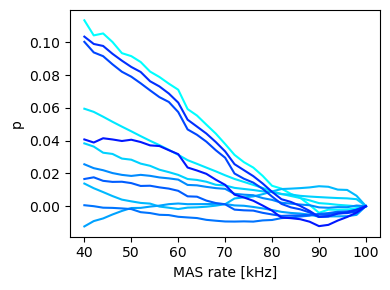

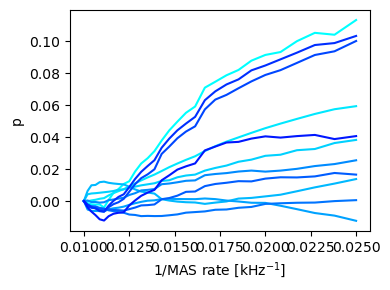

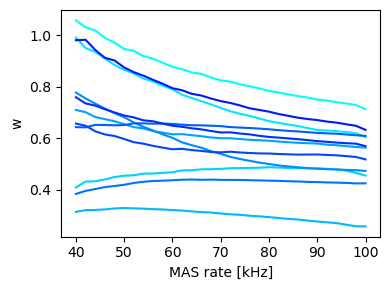

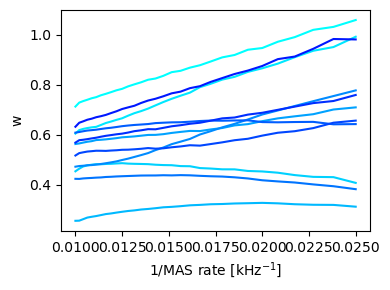

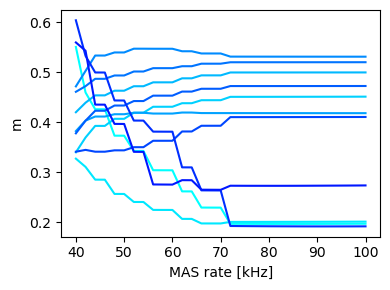

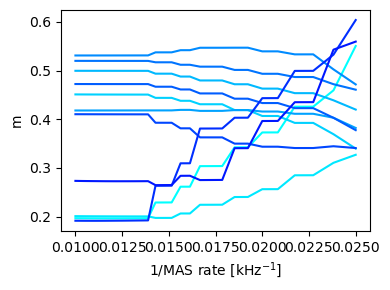

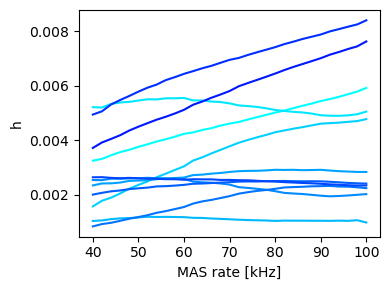

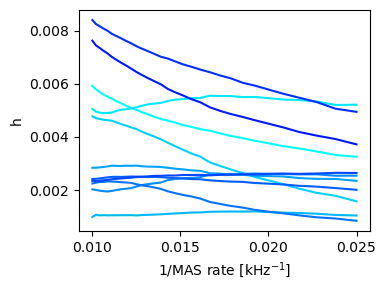

aspala


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


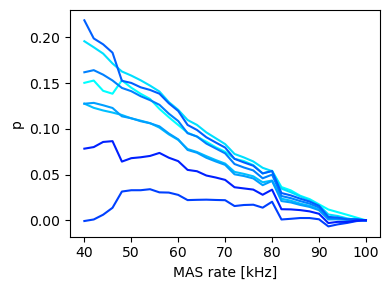

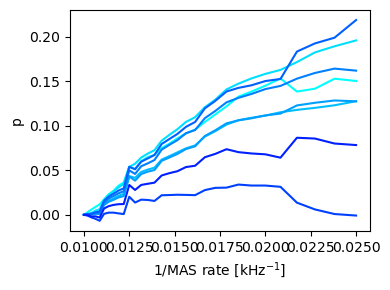

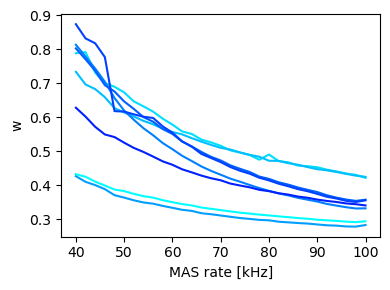

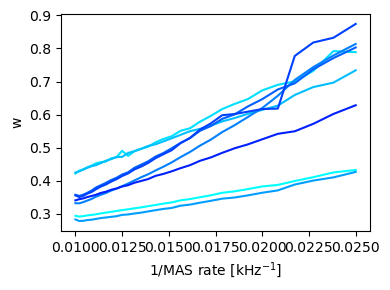

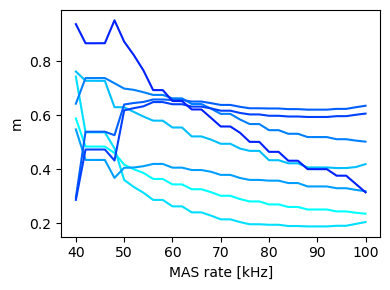

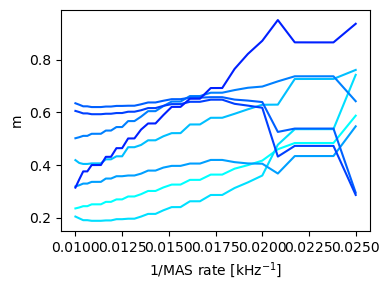

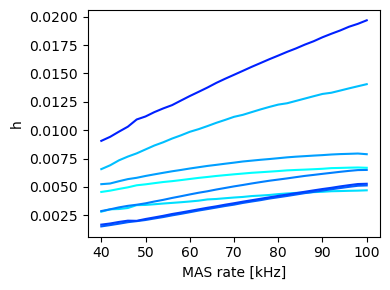

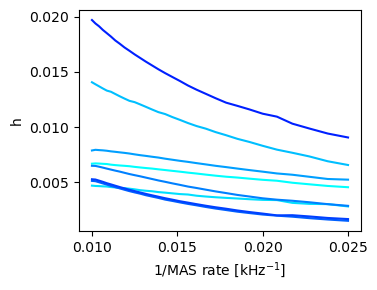

flutamide


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


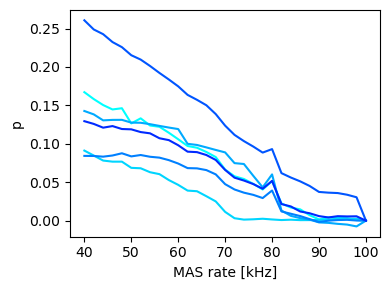

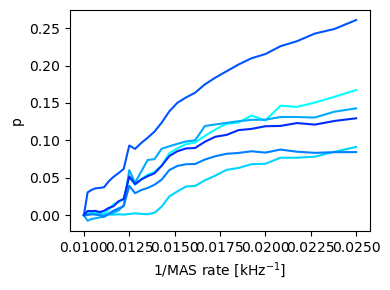

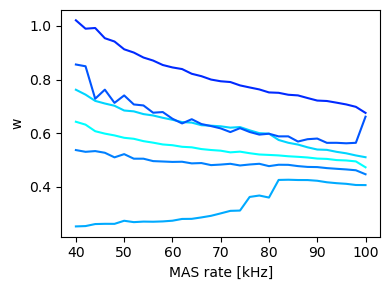

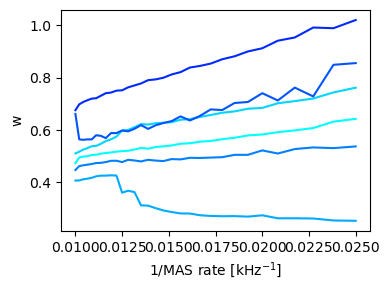

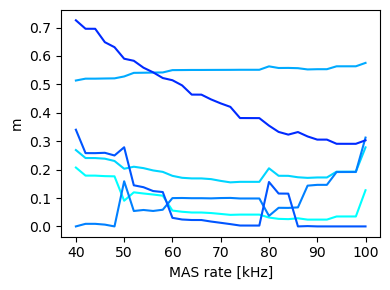

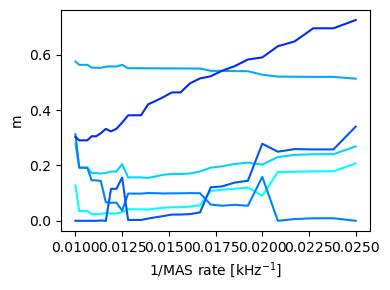

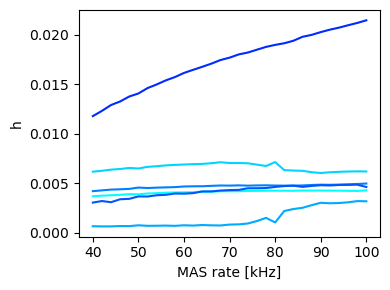

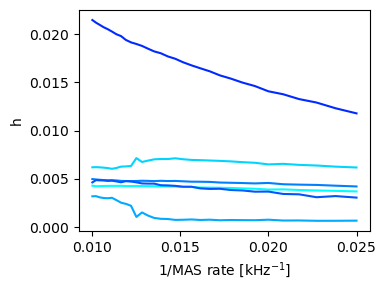

histidine


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


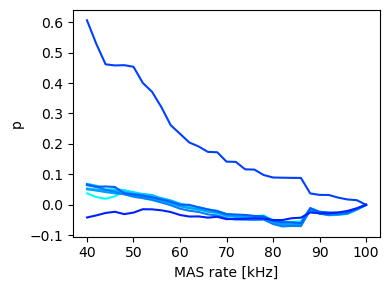

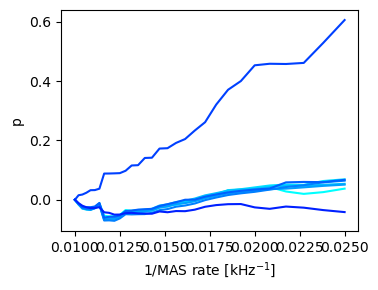

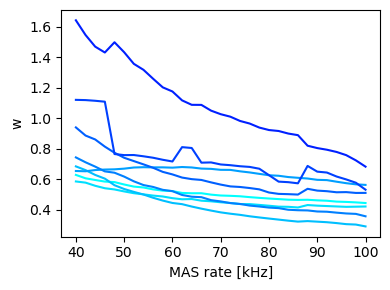

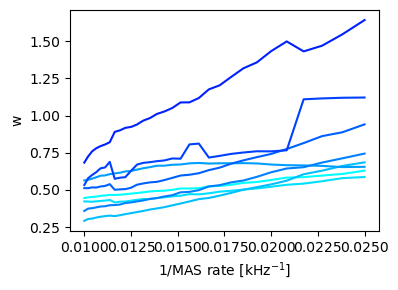

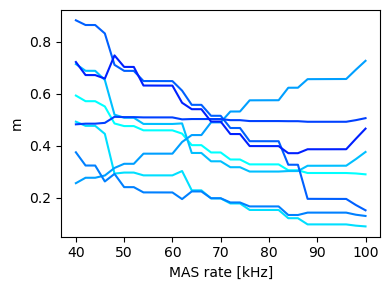

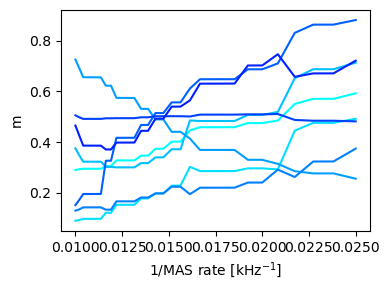

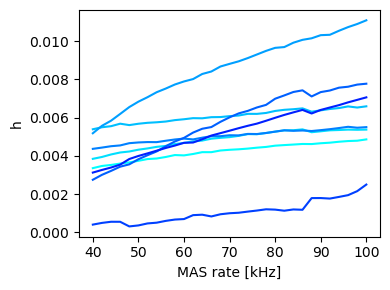

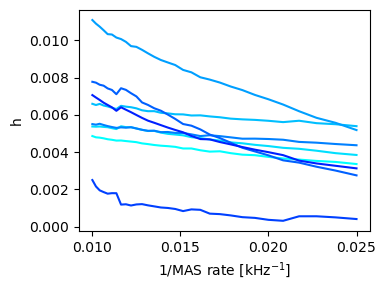

thymol


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


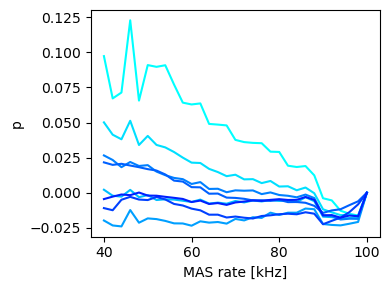

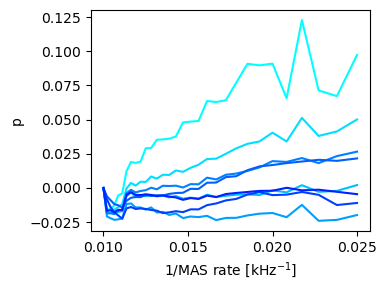

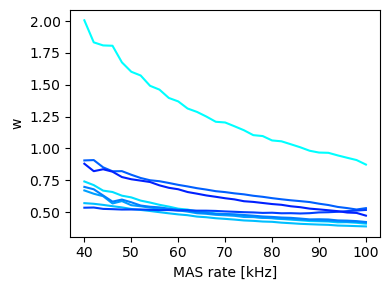

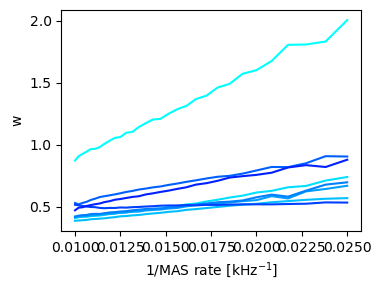

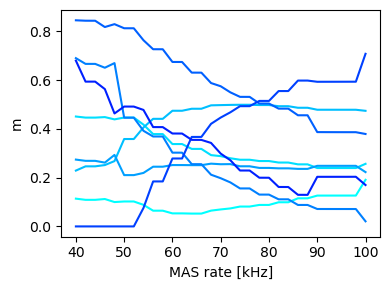

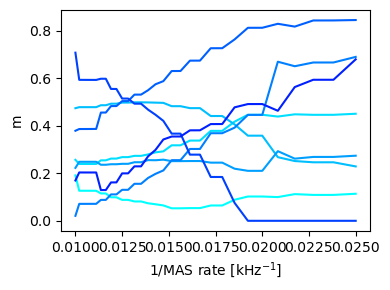

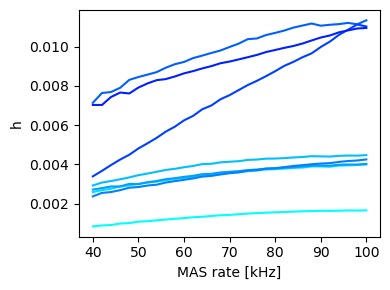

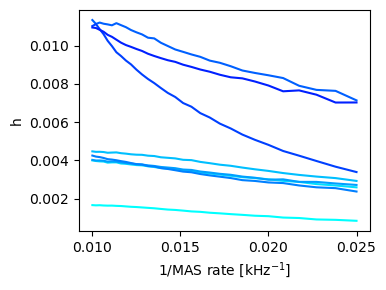

tyrosine


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


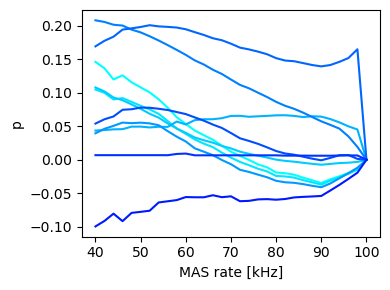

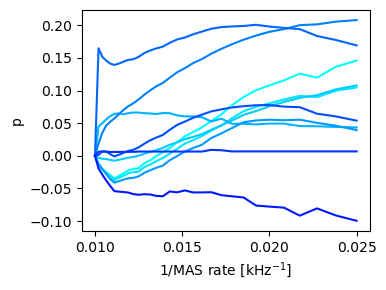

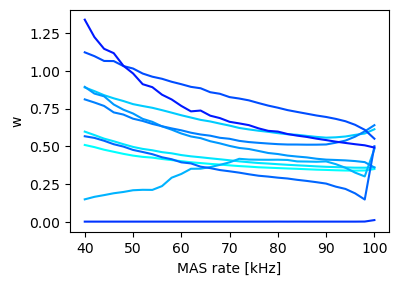

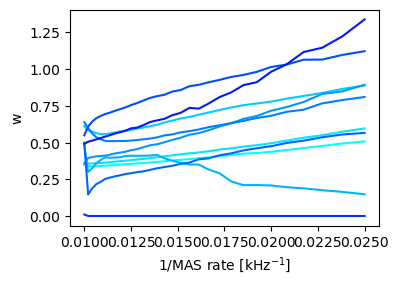

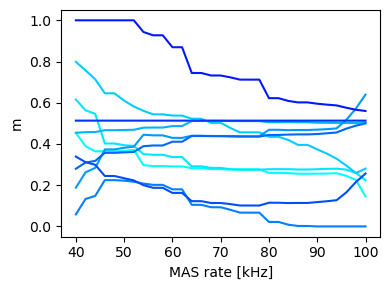

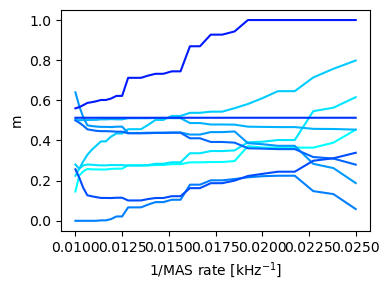

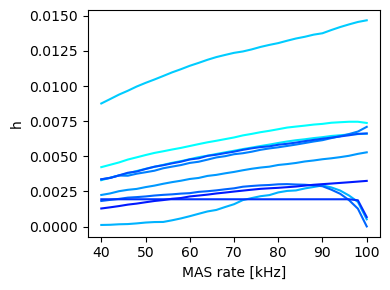

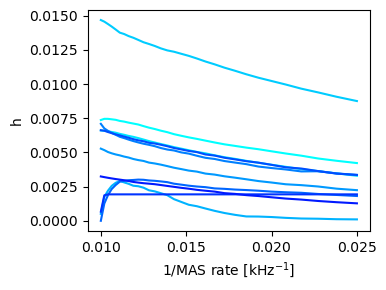

mdma


  0%|          | 0/31 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


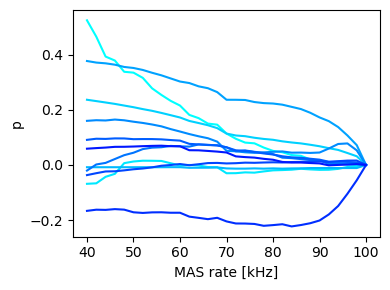

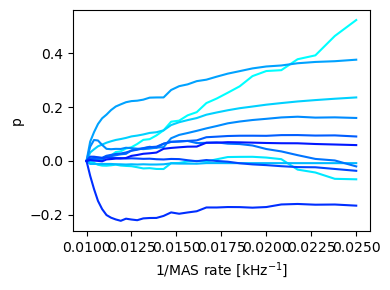

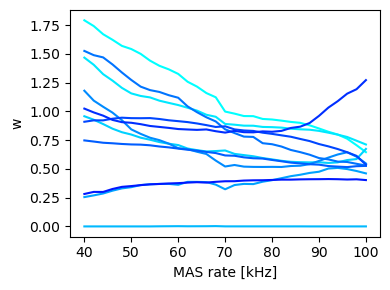

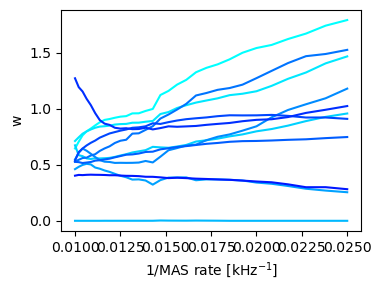

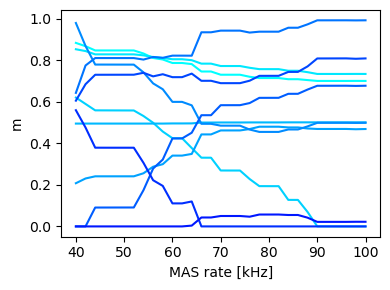

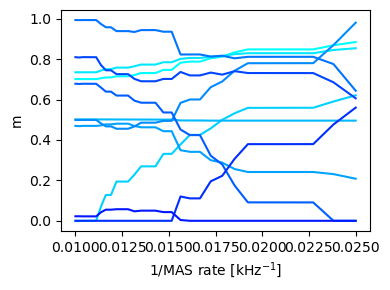

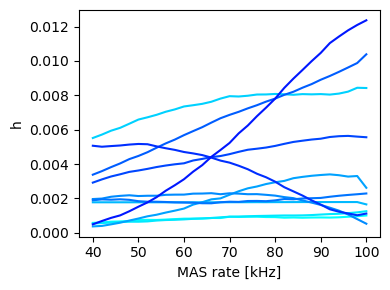

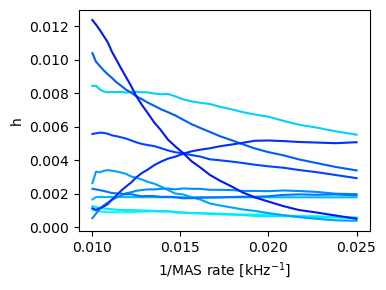

In [24]:
r0 = 20.
r1 = -5.
c0 = np.array([0., 1., 1.])
dc = np.array([0., -1., 0.])
dp = 0.2

wmax = 3.
n_init = 5
w_guess = 0.5
m_guess = 0.5

for compound, ppm, X, ws in zip(exp_compounds, ppms, Xs, all_ws):
    print(compound)

    fdir = f"{fig_dir}{compound}/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    for i, Xi in enumerate(X):
        ax.plot(ppm, Xi, color=c0 + i/(X.shape[0]-1) * dc, linewidth=1.)

    ax.set_xlim(r0, r1)
    ax.set_xlabel("Chemical shift [ppm]")
    ax.set_yticks([])
    fig.tight_layout()
    plt.savefig(f"{fdir}spectra.pdf")
    #plt.show()
    plt.close()

    fit_v = []
    fit_s = []
    fit_p = []

    fit_rmses_v = []
    fit_rmses_s = []
    fit_rmses_p = []

    inds = np.where(np.logical_and(ppm > r0, ppm < r1))
    
    all_res = []
    
    ps_guess = peak_pos_guess[compound]
    ws_guess = [w_guess for _ in ps_guess]
    ms_guess = [m_guess for _ in ps_guess]
    hs_guess = [Xi[np.argmin(np.abs(ppm - p))] for p in ps_guess]

    for i, (wi, Xi) in tqdm.tqdm(enumerate(zip(ws, X)), total=len(ws)):
        
        for _ in range(n_init):

            # Optimize height
            bounds = []
            x0 = []
            for h in hs_guess:
                bounds.append((0., np.max(Xi) * 1.1))
                x0.append(h)

            res = op.minimize(to_minimize_heights, x0, args=(ppm, ps_guess, ws_guess, ms_guess, Xi, gls),
                              jac="3-point", bounds=bounds, method="L-BFGS-B")

            hs_guess = res.x

            # Optimize width
            bounds = []
            x0 = []
            for w in ws_guess:
                bounds.append((1.e-6, wmax))
                x0.append(w)

            res = op.minimize(to_minimize_widths, x0, args=(ppm, ps_guess, ms_guess, hs_guess, Xi, gls),
                              jac="3-point", bounds=bounds, method="L-BFGS-B")
            
            ws_guess = res.x

            # Optimize mixing
            bounds = []
            x0 = []
            for m in ms_guess:
                bounds.append((0., 1.))
                x0.append(m)

            res = op.minimize(to_minimize_mixings, x0, args=(ppm, ps_guess, ws_guess, hs_guess, Xi, gls),
                              jac="3-point", bounds=bounds, method="L-BFGS-B")
            
            ms_guess = res.x

            # Optimize peaks
            bounds = []
            x0 = []
            for p in ps_guess:
                bounds.append((p-dp, p+dp))
                x0.append(p)

            res = op.minimize(to_minimize_peaks, x0, args=(ppm, ws_guess, ms_guess, hs_guess, Xi, gls),
                              jac="3-point", bounds=bounds, method="L-BFGS-B")
            
            ps_guess = res.x
        
        bounds = []
        x0 = []
        j = 0
        for p, w, m, h in zip(ps_guess, ws_guess, ms_guess, hs_guess):
            x0.append(p)
            bounds.append((p - dp, p + dp))
            x0.append(w)
            bounds.append((1.e-6, min(w * 1.1, wmax)))
            x0.append(m)
            bounds.append((0., 1.))
            x0.append(h)
            bounds.append((h * 0.9, h * 1.1))
            j += 3
        
        # Then optimize all parameters
        res = op.minimize(to_minimize, x0, args=(ppm, Xi, gls), bounds=bounds, jac="3-point",
                          method="L-BFGS-B", options={"maxiter": 1e6})
        print(res.success)
        
        all_res.append(res.x)
        
        # Update peak position guesses
        peak_guess = res.x[::4]
        
    all_res = np.array(all_res)
    
    for w, this_res, Xi in zip(ws, all_res, X):

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        ax.plot(ppm, Xi, linewidth=1.)
        y = gls_sum(ppm, this_res)
        ax.plot(ppm, y, linewidth=1.)

        ax.set_xlim(r0, r1)
        ax.set_yticks([])
        ax.set_xlabel("Chemical shift [ppm]")

        fig.tight_layout()
        plt.savefig(f"{fdir}fit_{w/1000.:.0f}_kHz.pdf")
        plt.close()

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        ax.plot(ppm, Xi, color="k", linewidth=1.)

        i = 0
        while i < len(this_res):
            y = gls(ppm, *this_res[i:i+4])
            ax.plot(ppm, y, linewidth=1., color=c0+(i/len(this_res)*dc))
            i += 4

        ax.set_xlim(r0, r1)
        ax.set_yticks([])
        ax.set_xlabel("Chemical shift [ppm]")

        fig.tight_layout()
        plt.savefig(f"{fdir}fit_{w/1000.:.0f}_kHz_sep.pdf")
        plt.close()
        
    fit_params = []
    pars = ["p", "w", "m", "h"]
    for j, p in enumerate(pars):

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        k = 0
        while k < all_res.shape[1]:

            if j == 0:
                ax.plot(ws / 1000., all_res[:, j+k] - all_res[0, j+k], color=c0+((k/all_res.shape[1])*dc))
            else:
                ax.plot(ws / 1000., all_res[:, j+k], color=c0+((k/all_res.shape[1])*dc))
            k += 4

        ax.set_ylabel(p)
        ax.set_xlabel("MAS rate [kHz]")

        fig.tight_layout()
        plt.savefig(f"{fdir}param_fit_{p}.pdf")
        plt.show()
        plt.close()
        
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        k = 0
        while k < all_res.shape[1]:

            if j == 0:
                ax.plot(1000. / ws, all_res[:, j+k] - all_res[0, j+k], color=c0+((k/all_res.shape[1])*dc))
            else:
                ax.plot(1000. / ws, all_res[:, j+k], color=c0+((k/all_res.shape[1])*dc))
            k += 4

        ax.set_ylabel(p)
        ax.set_xlabel("1/MAS rate [kHz$^{-1}$]")

        fig.tight_layout()
        plt.savefig(f"{fdir}param_fit_{p}_inv.pdf")
        plt.show()
        plt.close()